In [1]:
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from lifelines import KaplanMeierFitter
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

C:\Users\sapir\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# cleaning the data (dataset file attached to git file)
# note - categorical values: 0 = no, 1 = yes or 0 = female, 1 = male
data = pd.read_csv(os.path.abspath("heart_failure_clinical_records_dataset.csv"))
print(data.info())
abs_z_scores = np.abs(stats.zscore(
    data[["creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]]))
filtered_entries = (abs_z_scores < 3).all(axis=1)
data = data[filtered_entries]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB
None


In [3]:
# value settings
TRUE_FEATURE = 1
FALSE_FEATURE = 0
NUM_ROWS = 0
WIDTH = 0.3
SIZE18 = 18
CV10 = 10

In [17]:
# creat groups by age 

live = {}
dead = {}

def num_of_cases(name, x, y):
    age_group = data.loc[(data["age"] > x) & (data["age"] < y)]
    dead_from_age_group = (age_group.loc[age_group["DEATH_EVENT"] == TRUE_FEATURE]).shape[NUM_ROWS]
    live_from_age_group = (age_group.loc[age_group["DEATH_EVENT"] == FALSE_FEATURE]).shape[NUM_ROWS]
    live[name] = live_from_age_group
    dead[name] = dead_from_age_group


num_of_cases("40-49", 39, 50)
num_of_cases("50-59", 49, 60)
num_of_cases("60-69", 59, 70)
num_of_cases("70-79", 69, 80)
num_of_cases("80-89", 79, 90)
num_of_cases("90+", 89, 100)

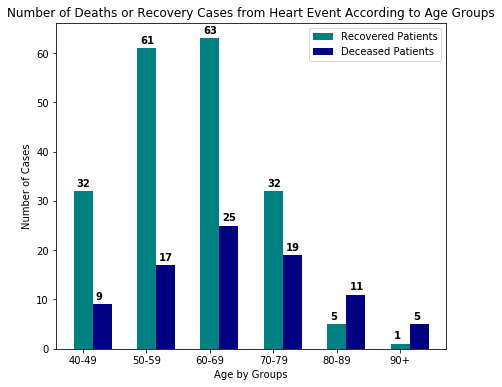

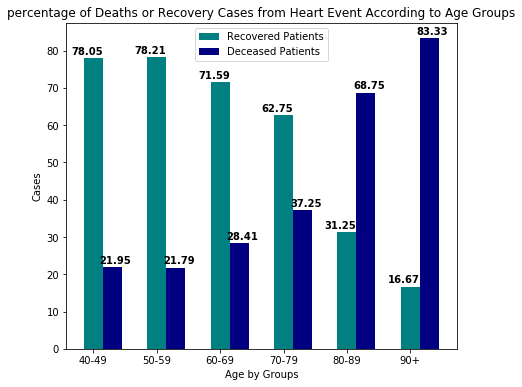

In [5]:
# bar chart - death event in age groups 
def age_bar(live_dic, dead_dic, title, y_label):
    plt.figure(figsize=(7, 6))
    bar1 = np.arange(len(live_dic.keys()))
    bar2 = [i + WIDTH for i in bar1]
    plt.bar(bar1, live_dic.values(), WIDTH, label="Recovered Patients", color="teal")
    plt.bar(bar2, dead_dic.values(), WIDTH, label="Deceased Patients", color="navy")
    plt.xticks(bar1, live_dic.keys())
    plt.title(title)
    plt.xlabel("Age by Groups")
    plt.ylabel(y_label)
    
age_bar(live, dead, "Number of Deaths or Recovery Cases from Heart Event According to Age Groups", "Number of Cases")
for i, v in enumerate(live.values()):
    plt.text(i - 0.1, v + 1, str(v), fontweight="bold")
for i, v in enumerate(dead.values()):
    plt.text(i + 0.2, v + 1, str(v), fontweight="bold")
plt.legend()
plt.show()

# same bar chart - by percentage
live_prc = {}
dead_prc = {}
for k in live:
    sum_ = dead[k] + live[k]
    live_prc[k] = round(live[k] / sum_ * 100, 2)
    dead_prc[k] = round(dead[k] / sum_ * 100, 2)
age_bar(live_prc, dead_prc, "percentage of Deaths or Recovery Cases from Heart Event According to Age Groups", "Cases")
for i, v in enumerate(live_prc.values()):
    plt.text(i - 0.35, v + 1, str(v), fontweight="bold")
for i, v in enumerate(dead_prc.values()):
    plt.text(i + 0.1, v + 1, str(v), fontweight="bold")
plt.legend()
plt.show()

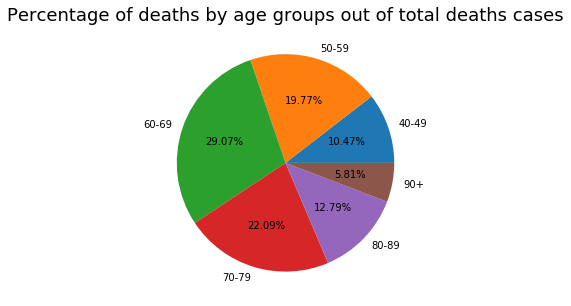

In [6]:
death_by_age = {}


def death_prc_age(group_name, x, y):
    # pie chart - death percentage for each age group from total number of death cases
    age_group = data.loc[(data["age"] > x) & (data["age"] < y)]
    dead_group = (age_group.loc[age_group["DEATH_EVENT"] == TRUE_FEATURE]).shape[NUM_ROWS]
    dead_prc = dead_group / data.loc[data["DEATH_EVENT"] == TRUE_FEATURE].shape[NUM_ROWS] * 100
    dead_prc = round(dead_prc, 2)
    death_by_age[group_name] = dead_prc


death_prc_age("40-49", 39, 50)
death_prc_age("50-59", 49, 60)
death_prc_age("60-69", 59, 70)
death_prc_age("70-79", 69, 80)
death_prc_age("80-89", 79, 90)
death_prc_age("90+", 89, 100)
plt.figure(figsize=(5, 5))
plt.pie(death_by_age.values(), labels=death_by_age.keys(), autopct="%1.2f%%")
plt.title("Percentage of deaths by age groups out of total deaths cases", size=SIZE18)
plt.show()

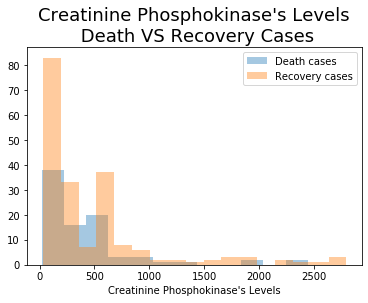

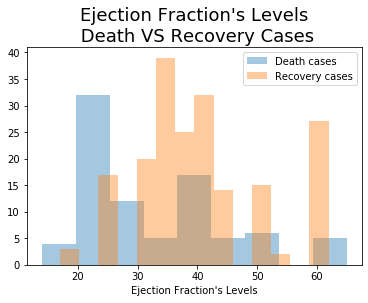

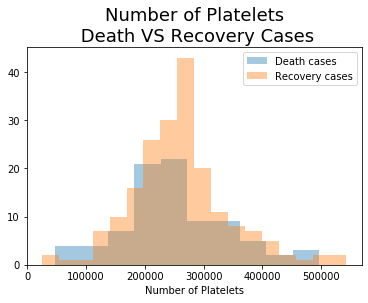

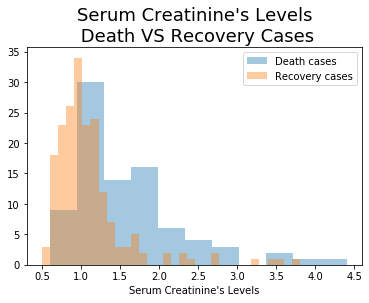

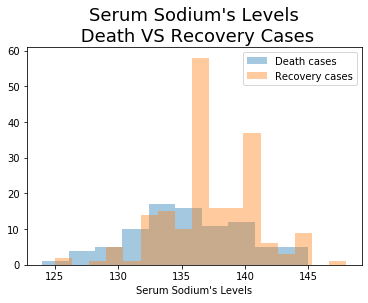

In [7]:
def dist_plot(column_name, title):
    # distribution plot for numerical columns - comparing death and recovery cases
    num_data = data[[column_name, "DEATH_EVENT"]]
    death = num_data.loc[num_data["DEATH_EVENT"] == TRUE_FEATURE]
    recovery = num_data.loc[num_data["DEATH_EVENT"] == FALSE_FEATURE]
    sns.distplot(death[column_name], kde=False, label="Death cases")
    sns.distplot(recovery[column_name], kde=False, label="Recovery cases")
    plt.xlabel(title)
    plt.title("{}\n Death VS Recovery Cases".format(title), size=SIZE18)
    plt.legend()
    plt.show()

dist_plot("creatinine_phosphokinase", "Creatinine Phosphokinase's Levels")
dist_plot("ejection_fraction", "Ejection Fraction's Levels")
dist_plot("platelets", "Number of Platelets")
dist_plot("serum_creatinine", "Serum Creatinine's Levels")
dist_plot("serum_sodium", "Serum Sodium's Levels")

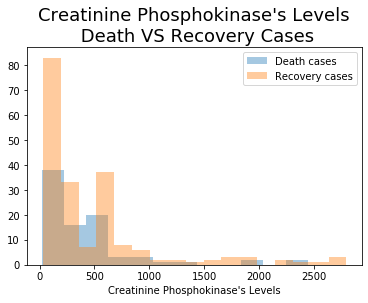

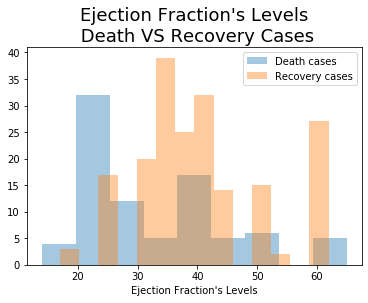

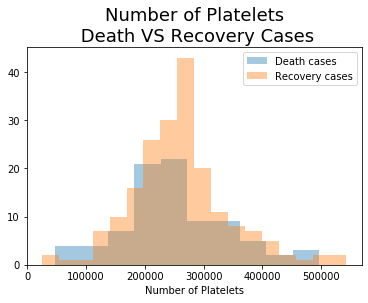

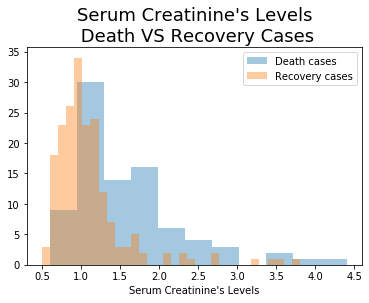

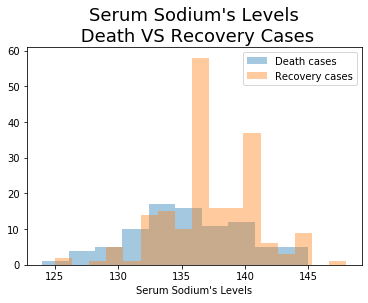

In [8]:
# numerical values - plot
def dist_plot(column_name, title):
    num_data = data[[column_name, "DEATH_EVENT"]]
    death = num_data.loc[num_data["DEATH_EVENT"] == 1]
    recovery = num_data.loc[num_data["DEATH_EVENT"] == 0]
    sns.distplot(death[column_name], kde = False, label = "Death cases")
    sns.distplot(recovery[column_name], kde = False, label = "Recovery cases")
    plt.xlabel(title)
    plt.title("{}\n Death VS Recovery Cases".format(title), size = 18)
    plt.legend()
    plt.show()
    
dist_plot("creatinine_phosphokinase", "Creatinine Phosphokinase's Levels")
dist_plot("ejection_fraction", "Ejection Fraction's Levels")
dist_plot("platelets", "Number of Platelets")
dist_plot("serum_creatinine", "Serum Creatinine's Levels")
dist_plot("serum_sodium", "Serum Sodium's Levels")


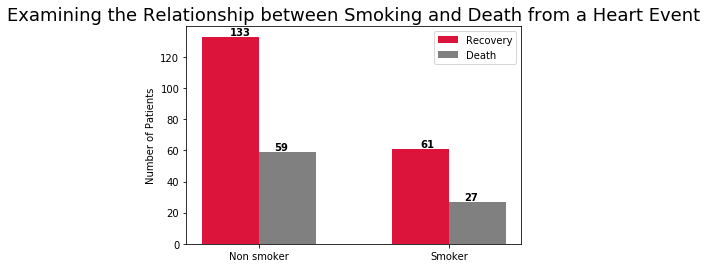

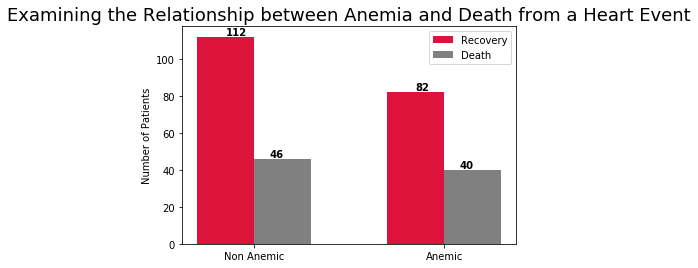

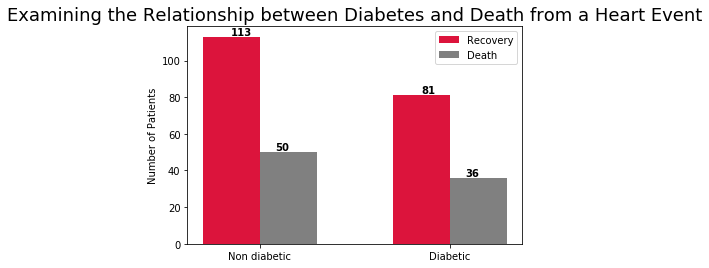

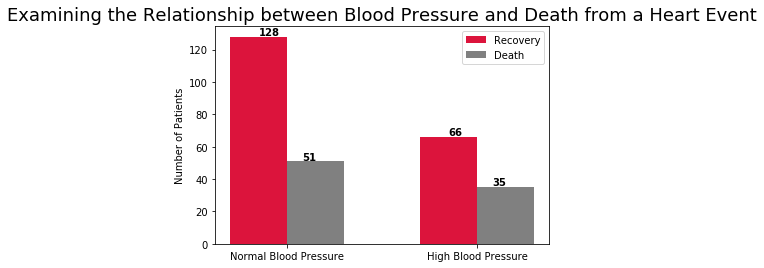

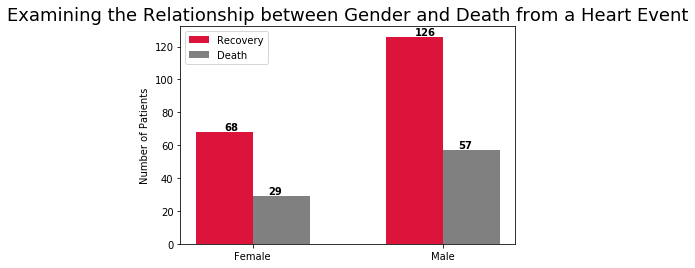

In [9]:
def cat_values(col, fls, tr, title):
    # bar chart for each categorical column divided by death or recovery
    live = [data.loc[(data[col] == FALSE_FEATURE) & (data["DEATH_EVENT"] == FALSE_FEATURE)].shape[NUM_ROWS],
            data.loc[(data[col] == TRUE_FEATURE) & (data["DEATH_EVENT"] == FALSE_FEATURE)].shape[NUM_ROWS]]
    death = [data.loc[(data[col] == FALSE_FEATURE) & (data["DEATH_EVENT"] == TRUE_FEATURE)].shape[NUM_ROWS],
             data.loc[(data[col] == TRUE_FEATURE) & (data["DEATH_EVENT"] == TRUE_FEATURE)].shape[NUM_ROWS]]
    ind = np.arange(2)
    fig, ax = plt.subplots()
    bar1 = ax.bar(ind - WIDTH / 2, live, WIDTH, label="Recovery", color="crimson")
    bar2 = ax.bar(ind + WIDTH / 2, death, WIDTH, label="Death", color="gray")
    ax.set_ylabel("Number of Patients")
    ax.set_title("Examining the Relationship between {} and Death from a Heart Event".format(title), size=SIZE18)
    ax.set_xticks(ind)
    ax.set_xticklabels((fls, tr))
    for i, v in enumerate(live):
        plt.text(i - 0.15, v + 1, str(v), fontweight="bold")
    for i, v in enumerate(death):
        plt.text(i + 0.08, v + 1, str(v), fontweight="bold")
    plt.legend()


cat_values("smoking", "Non smoker", "Smoker", "Smoking")
cat_values("anaemia", "Non Anemic", "Anemic", "Anemia")
cat_values("diabetes", "Non diabetic", "Diabetic", "Diabetes")
cat_values("high_blood_pressure", "Normal Blood Pressure", "High Blood Pressure", "Blood Pressure")
cat_values("sex", "Female", "Male", "Gender")

In [10]:
# bayes formula for categorical values
def probability(column_name, binary, title):
    PAB = data.loc[(data["DEATH_EVENT"] == TRUE_FEATURE) & (data[column_name] == binary)].shape[NUM_ROWS]
    PA = data.loc[data[column_name] == binary].shape[NUM_ROWS]
    print("The probability of {0} to die from a heart failure is {1}%".format(title, round(PAB / PA * 100, 2)))


probability("smoking", 1, "a smoker")
probability("anaemia", 1, "an anemic")
probability("diabetes", 1, "a diabetic")
probability("high_blood_pressure", 1, "a patient with high blood pressure")
probability("sex", 1, "a male")
probability("sex", 0, "a female")

The probability of a smoker to die from a heart failure is 30.68%
The probability of an anemic to die from a heart failure is 32.79%
The probability of a diabetic to die from a heart failure is 30.77%
The probability of a patient with high blood pressure to die from a heart failure is 34.65%
The probability of a male to die from a heart failure is 31.15%
The probability of a female to die from a heart failure is 29.9%


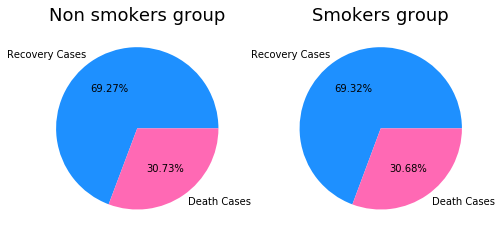

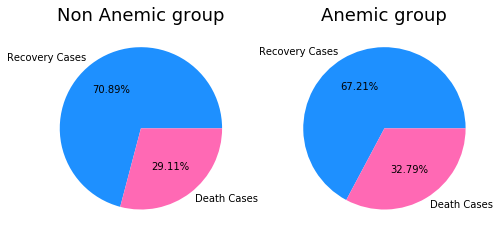

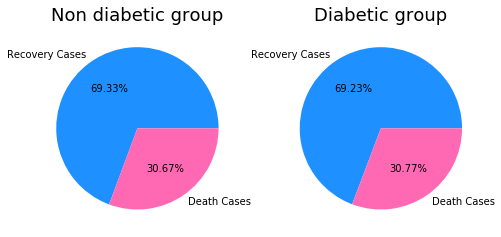

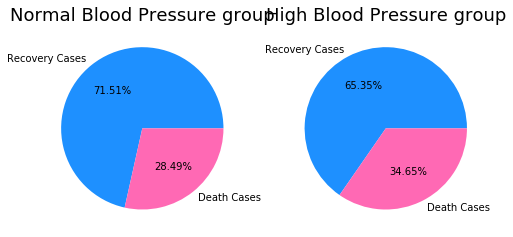

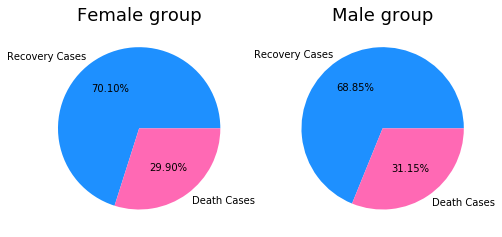

In [11]:
def cat_val_pie(column_name, fls_title, tr_title):
    # pie chart showing death VS recovery percentage in categorical columns
    fls = data.loc[(data[column_name] == FALSE_FEATURE) & (data["DEATH_EVENT"] == FALSE_FEATURE)].shape[NUM_ROWS]
    fls = round(fls / data.loc[data[column_name] == FALSE_FEATURE].shape[NUM_ROWS] * 100, 2)
    fls_pie = [fls, 100 - fls]
    tr = data.loc[(data[column_name] == TRUE_FEATURE) & (data["DEATH_EVENT"] == FALSE_FEATURE)].shape[NUM_ROWS]
    tr = round(tr / data.loc[data[column_name] == TRUE_FEATURE].shape[NUM_ROWS] * 100, 2)
    tr_pie = [tr, 100 - tr]
    plt.subplots(1, 2, figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.pie(fls_pie, labels=["Recovery Cases", "Death Cases"],
            autopct="%1.2f%%", colors=["dodgerblue", "hotpink"])
    plt.title("{} group".format(fls_title), size=SIZE18)
    plt.subplot(1, 2, 2)
    plt.pie(tr_pie, labels=["Recovery Cases", "Death Cases"],
            autopct="%1.2f%%", colors=["dodgerblue", "hotpink"])
    plt.title("{} group".format(tr_title), size=SIZE18)


cat_val_pie("smoking", "Non smokers", "Smokers")
cat_val_pie("anaemia", "Non Anemic", "Anemic")
cat_val_pie("diabetes", "Non diabetic", "Diabetic")
cat_val_pie("high_blood_pressure", "Normal Blood Pressure", "High Blood Pressure")
cat_val_pie("sex", "Female", "Male")

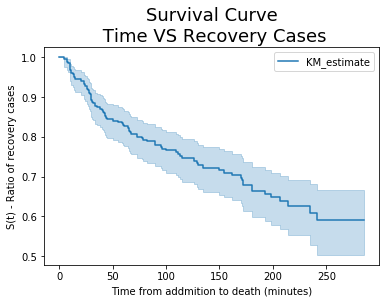

In [12]:
# KM curve - time VS death event
kmf = KaplanMeierFitter()
kmf.fit(data["time"], data["DEATH_EVENT"])
kmf.plot()
plt.xlabel("Time from addmition to death (minutes)")
plt.ylabel("S(t) - Ratio of recovery cases")
plt.title("Survival Curve\n Time VS Recovery Cases", size=SIZE18)
plt.show()

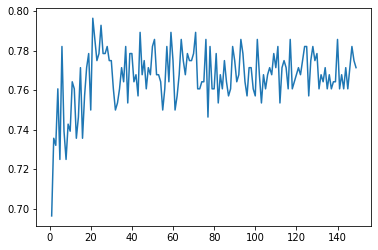

model prediction score: 0.98


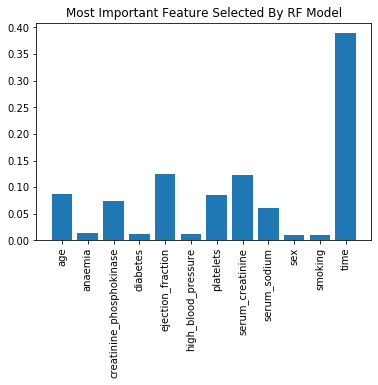

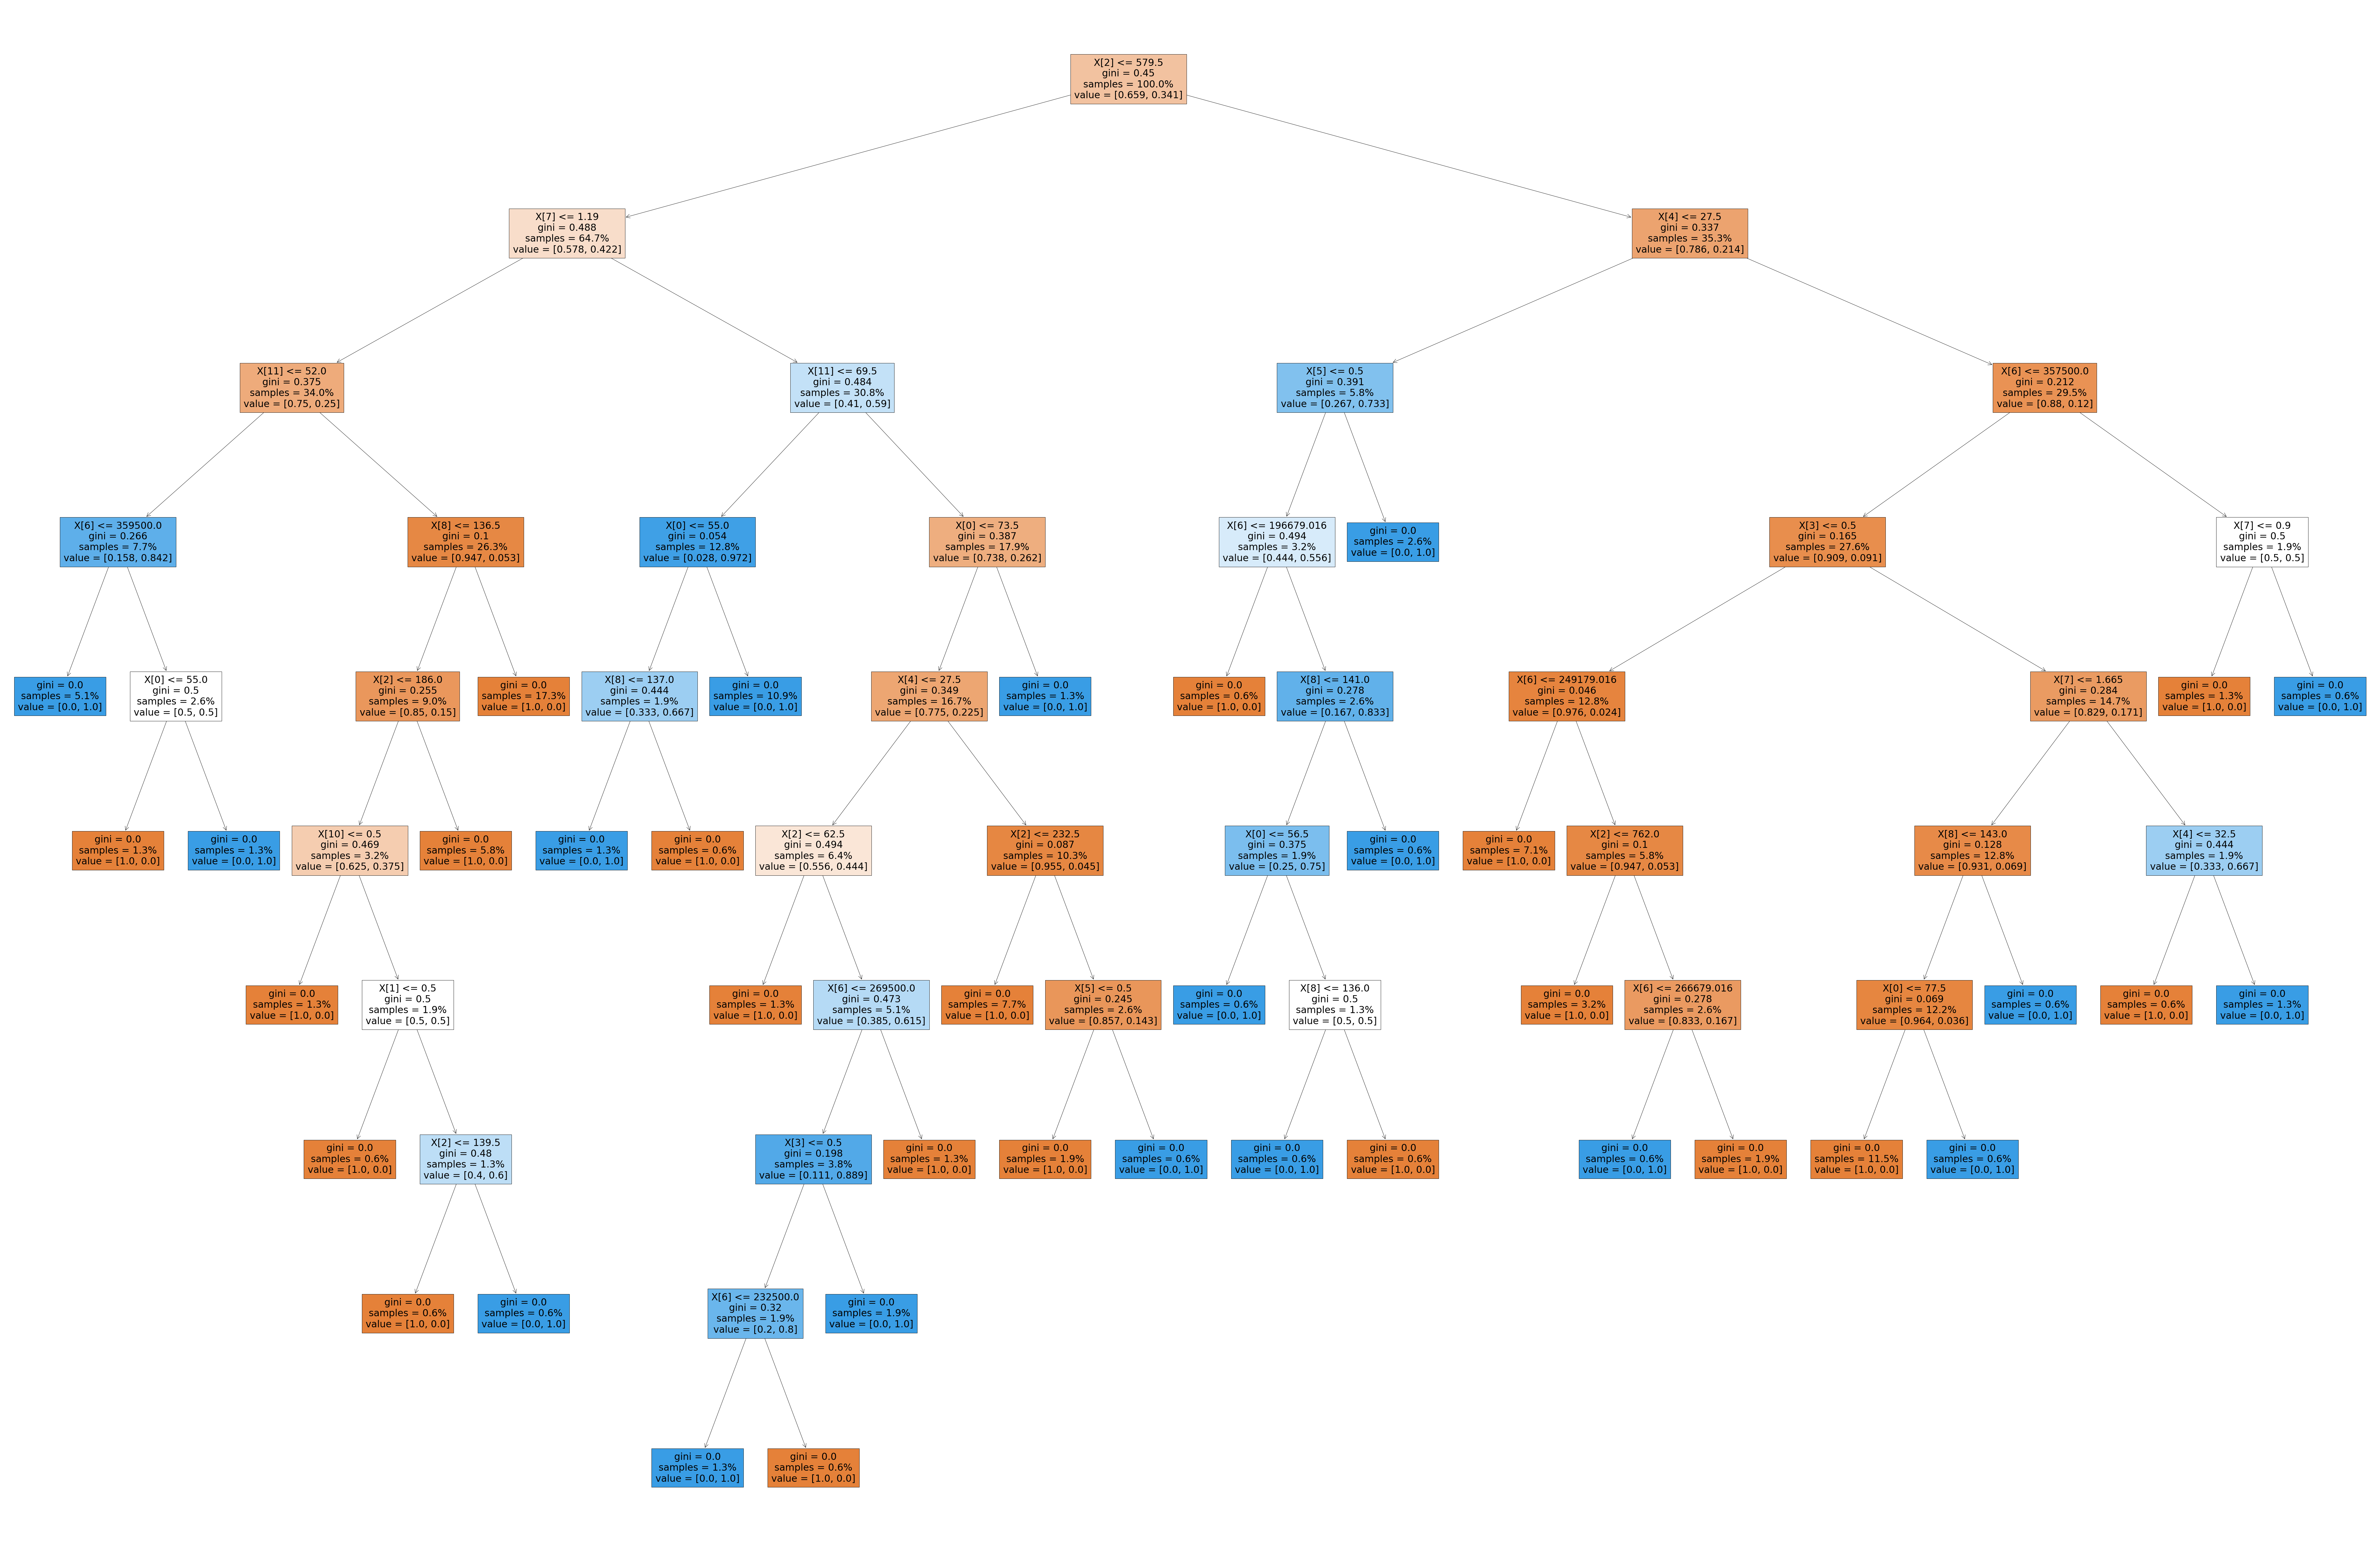

In [13]:
# random forest classification model (model + pictures attached to git folder)
no_death_data = data.drop("DEATH_EVENT", 1)
num_range = range(1, 150)
num_score = []
for num in num_range:
    model = RandomForestClassifier(n_estimators=num)
    score = cross_val_score(model, no_death_data, data["DEATH_EVENT"], cv=CV10, scoring="accuracy")
    num_score.append(score.mean())
plt.plot(num_range, num_score)
plt.show()
max_ne = [i for i in range(len(num_score)) if num_score[i] == max(num_score)]
max_ne = num_range[max_ne[0]]
if os.path.isfile(os.path.abspath("model.pkl")) == True:
    model = joblib.load("model.pkl")
else:
    model = RandomForestClassifier(n_estimators=max_ne)
    x_train, x_test, y_train, y_test = train_test_split(no_death_data, data["DEATH_EVENT"], random_state=42,
                                                        test_size=0.1,
                                                        stratify=data["DEATH_EVENT"])
    model.fit(x_train, y_train)
    joblib.dump(model, "model.pkl")

# model score
pred = model.predict(no_death_data)
score = accuracy_score(pred, data["DEATH_EVENT"])
print("model prediction score: " + str(round(score, 2)))

# important features
features = dict(zip(no_death_data.columns, model.feature_importances_))
plt.bar(features.keys(), features.values())
plt.xticks(rotation="vertical")
plt.title("Most Important Feature Selected By RF Model")
plt.show()

# picture
plt.figure(figsize=(150, 100))
for i in range(1, max_ne, 10):
    tree.plot_tree(model.estimators_[i], filled=True, proportion=True)
    plt.savefig("model" + str(i) + ".png")

In [14]:
# normalization of the data
for col in data:
    data[col] = data[col].apply(lambda num: num / data[col].max())

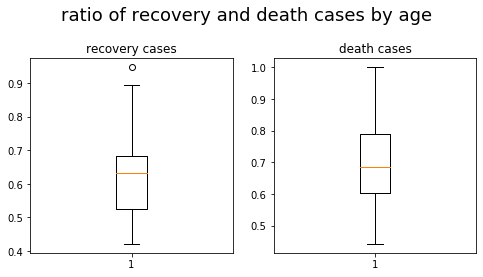

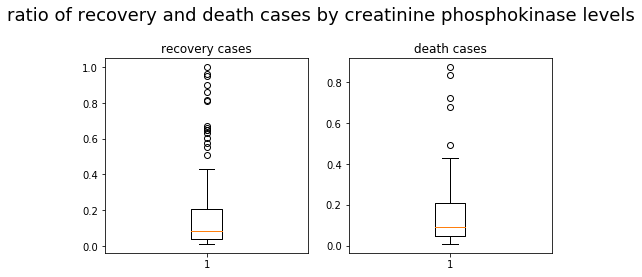

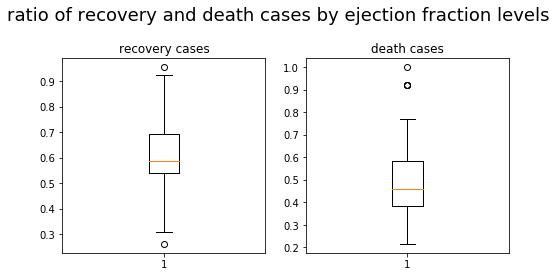

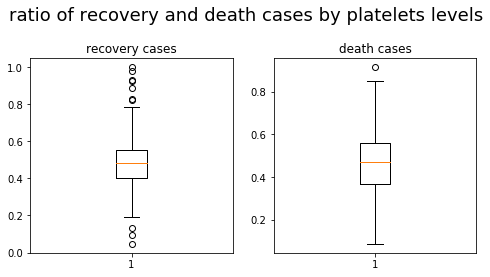

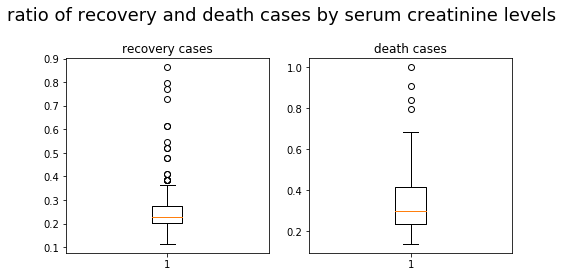

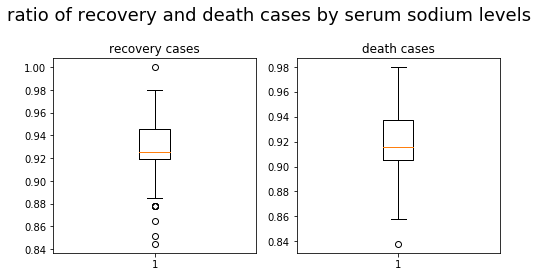

In [15]:
def boxplot(column_name, binary, title):
    # box plot - numerical values after normalization: death VS recovery
    boxplot_data = data[[column_name, "DEATH_EVENT"]]
    graph = boxplot_data.loc[boxplot_data["DEATH_EVENT"] == binary]
    plt.boxplot(graph[column_name])
    plt.title(title)


def subplot(column_name, main_title):
    f, axs = plt.subplots(1, 2, figsize=(8, 4))
    f.suptitle("ratio of recovery and death cases by {}".format(main_title), size=SIZE18)
    plt.subplots_adjust(top=0.8)
    plt.subplot(1, 2, 1)
    boxplot(column_name, 0, "recovery cases")
    plt.subplot(1, 2, 2)
    boxplot(column_name, 1, "death cases")
    plt.show()


subplot("age", "age")
subplot("creatinine_phosphokinase", "creatinine phosphokinase levels")
subplot("ejection_fraction", "ejection fraction levels")
subplot("platelets", "platelets levels")
subplot("serum_creatinine", "serum creatinine levels")
subplot("serum_sodium", "serum sodium levels")


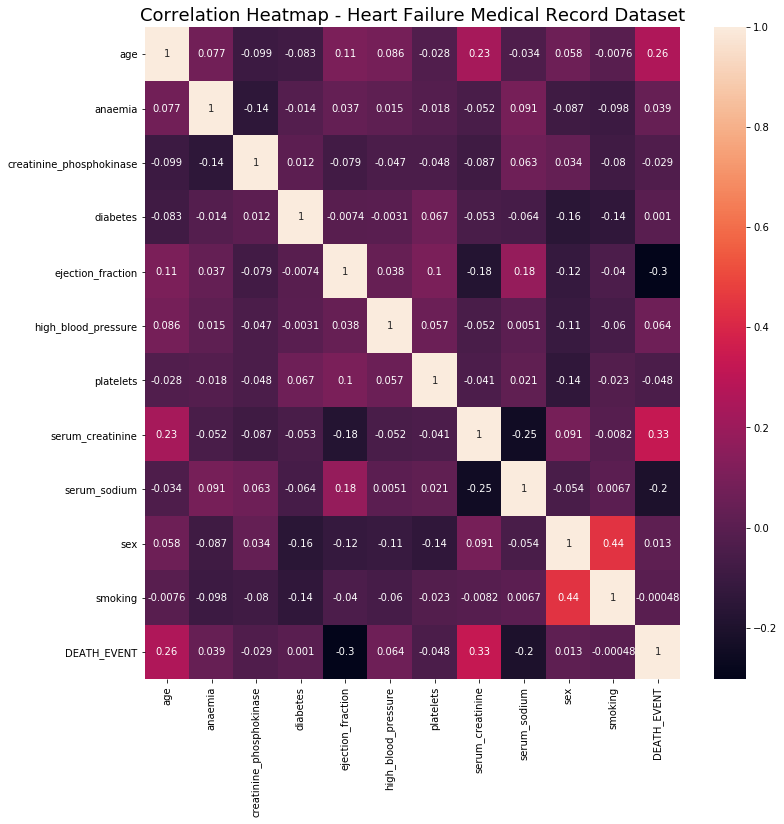

In [16]:
# correlation - heatmap for all values (- time) 
data = data.drop("time", 1)
plt.figure(figsize=(12, 12))
sns.heatmap(data.corr(), annot=True)
plt.title("Correlation Heatmap - Heart Failure Medical Record Dataset", size=SIZE18)
plt.show()